# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import copy

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    tnsfm=transforms.Compose([transforms.Resize((image_size,image_size)),
                              transforms.ToTensor(),
                             ])

    
    return torch.utils.data.DataLoader(datasets.ImageFolder(data_dir,transform=tnsfm),batch_size=batch_size,shuffle=True)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

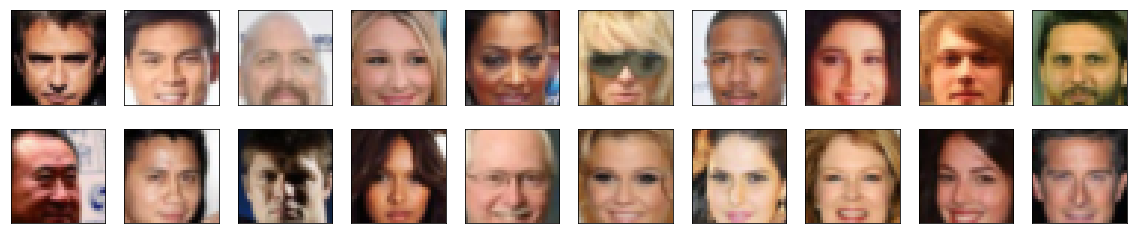

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=min(20,batch_size)
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    return x*(feature_range[1]-feature_range[0])+feature_range[0]


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9373)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv1=nn.Conv2d(conv_dim,conv_dim,3,1,1)
        self.bn1=nn.BatchNorm2d(conv_dim)
        self.conv2=nn.Conv2d(conv_dim,conv_dim,3,1,1)
        self.bn2=nn.BatchNorm2d(conv_dim)
        self.act=nn.ReLU()
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)       
        
        return self.act( x + self.bn2( self.conv2( self.act( self.bn1(self.conv1(x)) ) ) ) )

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, n_res=1):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3,conv_dim,4,2,1) # 16,16,64
        
        self.res0 = ResidualBlock(conv_dim)
        
        self.conv2 = nn.Conv2d(conv_dim,conv_dim*2,4,2,1,bias=False) # 8,8,128
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        
        res=[]
        for _ in range(n_res):
            res.append(ResidualBlock(conv_dim*2))
        self.res = nn.Sequential(*res)
        
        self.conv3 = nn.Conv2d(conv_dim*2,conv_dim*4,4,2,1,bias=False) # 4,4,256
        self.bn3 = nn.BatchNorm2d(conv_dim*4)
        
        self.conv4 = nn.Conv2d(conv_dim*4,1,4,1,0) # 1,1,1
        
        self.act=nn.LeakyReLU(negative_slope=0.2)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = self.act(self.conv1(x))
        x = self.res0(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.res(x)
        x = self.act(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        
        return nn.Sigmoid()(x.squeeze(3).squeeze(2))
        # I realize that we omitted this final sigmoid activation in some of the mini-projects
        # But I'm not sure why. It seems like we need to squash D to (0,1) for things to make sense...


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim, n_res=0):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        
        self.z_size_sliced = z_size - z_size%16
        if z_size%16 != 0:
            print("Warning: The last few components of z vectors will always get dropped by this model.\nYou should make z_size a multiple of 16\n")
            

        self.first_channels = self.z_size_sliced//16 # number of channels in first conv layer
        
        self.conv0 = nn.Conv2d(self.first_channels,conv_dim*4,3,1,1,bias=False)
        self.bn0 = nn.BatchNorm2d(conv_dim*4)
        
        
        res=[]
        for _ in range(n_res):
            res.append(ResidualBlock(conv_dim*4))
        self.res1 = nn.Sequential(*res)
        
        self.conv1 = nn.ConvTranspose2d(conv_dim*4,conv_dim*2,4,2,1,bias=False)
        self.bn1 = nn.BatchNorm2d(conv_dim*2)
        
        res=[]
        for _ in range(n_res):
            res.append(ResidualBlock(conv_dim*2))
        self.res2 = nn.Sequential(*res)
        
        self.conv2 = nn.ConvTranspose2d(conv_dim*2,conv_dim,4,2,1,bias=False)
        self.bn2 = nn.BatchNorm2d(conv_dim)
        
        self.conv3 = nn.ConvTranspose2d(conv_dim,3,4,2,1)
        
        self.act=nn.ReLU()
        self.final_act=nn.Tanh()

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """

        x = x.narrow(1,0,self.z_size_sliced)
        x = x.view(-1,self.first_channels,4,4)
        x = self.act(self.bn0(self.conv0(x)))

        x = self.res1(x)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.res2(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.final_act(self.conv3(x))
        
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

You should make z_size a multiple of 16

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # This is how I would initialize weights as described above:
#     if classname in ['Conv2d' or 'ConvTranspose2d']:
#         m.weight.data.normal_(0,0.02)
    
    # Please see cell below to understand why I chose to pass on custom weight initalization.
    
    

I chose not to implement this custom weight initialization, because I'm actually more willing to trust the default weight initialization instead. In the DCGAN paper linked above, the authors don't really give a convincing reason for their choice of weight initialization. It might be that they just wanted to make their results simple for others to reproduce, which is great but not necessary for me here.

The [documentation](https://pytorch.org/docs/stable/nn.html#conv2d) says that initial convolultional kernel tensor entries will be pulled from a uniform distribution $U(-\sqrt{k},\sqrt{k})$ where
$$ k = \frac{1}{\text{num_channels}\times\text{kernel_size}^2}. $$
I'm more comfortable with this because it's the [tried and true](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) standard weight initialization, and also it's not so different from the one in the DCGAN paper in typical situations. For example with 128 channels and $4\times 4$ kernel, we have $\sqrt{k}\approx 0.022$.

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (res0): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

run_id = '16'

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr=3e-4,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=1e-3,betas=(0.5,0.999))

In [18]:
# helper function for viewing a passed in list of sample images
def view_sample(samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
# A custom learning rate scheduler class written specifically for discriminators
# Weird that torch.optim.lr_scheduler doesn't have something like this for me to use

class LR_updater(object):
    def __init__(self,optimizer,M=2,gamma=0.2,lo_thresh=0.01,hi_thresh=0.1,verbose=None):
        '''Manages learning rate updates during training.
           Initialize it before training by giving it an optimizer,
           then call the method update(), passing in a loss, to update the optimizer's learning rate.
           
           param, optimizer: The optimizer whose learning rate is to be managed
           param, M: If M consecute updates show passed in loss to be beyond thresholds, certain things happen
           param, gamma: The scale factor by which to scale down learning rate when enough losses are below lo_thresh
           param, lo_thresh: When M consecutive updates show loss being below lo_thresh, learning rate will be reduced
           param, hi_thresh: When M consecutive updates show loss being above hi_thresh, learning rate is reset
                             back to its initial value.
           param, verbose: If this is set to be a string that serves as a name for the optimizer, some info will output
        '''
        self.optimizer = optimizer
        self.M=M
        self.gamma=gamma
        self.lo_thresh=lo_thresh
        self.hi_thresh=hi_thresh
        self.verbose=verbose
        
        self.reset_counters()
        self.initial_LRs = [gp['lr'] for gp in self.optimizer.param_groups]
        self.lr_is_reduced = False
        
    def update(self,d_loss):
        """Examines d_loss and increments internal counters to track consecutive beyond-threshold losses,
           and carries out the appropriate learning rate update if there are enough such losses.
        """
        if d_loss < self.lo_thresh:
            self.too_low_counter += 1
        else:
            self.too_low_counter = 0
        if d_loss > self.hi_thresh:
            self.high_enough_counter += 1
        else:
            self.high_enough_counter = 0
        if self.too_low_counter >= self.M:
            if self.verbose: print("Scaling down {} learning rate from {}".format(self.verbose,self.get_an_lr()))
            self.scale_down_lrs()
            self.reset_counters()
            if self.verbose: print("to new learning rate of {}.".format(self.get_an_lr()))
        if self.high_enough_counter >= self.M and self.lr_is_reduced:
            self.reset_lrs()
            self.reset_counters()
                
    def permanent_scaling(self,scale_factor):
        """Permanently scale learning rates by amount scale_factor"""
        self.reset_lrs()
        self.reset_counters()
        if self.verbose: print("Permanently scaling down {} learning rate from {}".format(self.verbose,self.get_an_lr()))
        for gp in self.optimizer.param_groups:
            gp['lr'] *= scale_factor
        self.initial_LRs = [gp['lr'] for gp in self.optimizer.param_groups]
        if self.verbose: print("to a new learning rate of {}.".format(self.get_an_lr()))
        

    def reset_counters(self):
        self.too_low_counter = 0 
        self.high_enough_counter = 0

    def get_an_lr(self,):
        return self.optimizer.param_groups[0]['lr']
        
    def scale_down_lrs(self,):
        for gp in self.optimizer.param_groups:
            gp['lr'] *= self.gamma
        self.lr_is_reduced = True
        
    def reset_lrs(self,):
        for gp,init_lr in zip(self.optimizer.param_groups,self.initial_LRs):
            gp['lr'] = init_lr
        self.lr_is_reduced = False
        if self.verbose: print("Learning rate for {} has been reset.".format(self.verbose))
            

            
# Initialize learning rate updaters

d_lr_updater = LR_updater(d_optimizer,M=2,gamma=0.2,lo_thresh=0.05,hi_thresh= 0.2,verbose="D")
g_lr_updater = LR_updater(g_optimizer,M=2,gamma=0.2,lo_thresh=-0.65,hi_thresh=-0.2,verbose="G")

In [20]:
def train(D, G, n_epochs, print_every=50, unroll_steps=15):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses AND update learning rate
       param, unroll_steps: number of D steps to unroll for each update of G
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    assert(unroll_steps>=0)
    d_loss_running_avg = 0
    g_loss_running_avg = 0
    print_every_ctr = 0

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu: z = z.cuda()
            fake_images = G(z)
            
            D_out_real = D(real_images)
            D_out_fake = D(fake_images)
            
            # 1. Train the discriminator on real and fake images
            d_loss = real_loss(D_out_real) + fake_loss(D_out_fake)
            d_optimizer.zero_grad()
            d_loss.backward(retain_graph=(unroll_steps==0)) # if unroll_steps==0 there's a simpler way to proceed
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            if unroll_steps>0:
                D_state_dict_backup = copy.deepcopy(D.state_dict())
                D_optim_state_dict_backup = copy.deepcopy(d_optimizer.state_dict())
                for _ in range(unroll_steps):
                    real_images2 = scale(next(iter(celeba_train_loader))[0])
                    if train_on_gpu: real_images2=real_images2.cuda()
                    z2 = np.random.uniform(-1, 1, size=(batch_size, z_size))
                    z2 = torch.from_numpy(z2).float()
                    if train_on_gpu: z2 = z2.cuda()
                    fake_images = G(z2)
                    d_loss2 = real_loss(D(real_images2)) + fake_loss(D(fake_images))
                    d_optimizer.zero_grad()
                    d_loss2.backward(create_graph=True)
                    d_optimizer.step()
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                if train_on_gpu: z = z.cuda()
                fake_images = G(z)
                g_loss = real_loss(D(fake_images))
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
                D.load_state_dict(D_state_dict_backup)
                d_optimizer.load_state_dict(D_optim_state_dict_backup)
            else: 
                # if unroll_steps == 0 then this is all we really need. retain_graph=True above saves us
                # from having to generate new fakes here.
                g_loss = real_loss(D_out_fake)
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
                
            
            # Accumulate running averages for losses. This is what I really want to print out and plot later.
            d_loss_running_avg =  (print_every_ctr*d_loss_running_avg + d_loss.item()) / (print_every_ctr + 1)
            g_loss_running_avg =  (print_every_ctr*g_loss_running_avg + g_loss.item()) / (print_every_ctr + 1)
            print_every_ctr += 1
            
            # Update learning rates
            d_lr_updater.update(d_loss.item())
            g_lr_updater.update(-d_loss.item()) # this is my funky way of re-using some code
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss_running_avg, g_loss_running_avg))
                
                # Reset running avergaes for losses
                d_loss_running_avg = 0
                g_loss_running_avg = 0
                print_every_ctr = 0


                
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        view_sample(samples_z)
        G.train() # back to training mode
        # Permanently scale down learning rates after each epoch
        d_lr_updater.permanent_scaling(0.3)
        g_lr_updater.permanent_scaling(0.3)

    # Save training generator samples
    with open('train_samples'+run_id+'.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/    5] | d_loss: 0.5040 | g_loss: 0.9593
Scaling down D learning rate from 0.0003
to new learning rate of 5.9999999999999995e-05.
Learning rate for D has been reset.
Scaling down D learning rate from 0.0003
to new learning rate of 5.9999999999999995e-05.
Learning rate for D has been reset.
Epoch [    1/    5] | d_loss: 0.1195 | g_loss: 0.9514
Epoch [    1/    5] | d_loss: 0.1106 | g_loss: 0.9324
Scaling down D learning rate from 0.0003
to new learning rate of 5.9999999999999995e-05.
Epoch [    1/    5] | d_loss: 0.0958 | g_loss: 0.9059
Learning rate for D has been reset.
Epoch [    1/    5] | d_loss: 0.2305 | g_loss: 0.8764
Epoch [    1/    5] | d_loss: 0.2372 | g_loss: 0.8972
Epoch [    1/    5] | d_loss: 0.2108 | g_loss: 0.9105
Epoch [    1/    5] | d_loss: 0.1458 | g_loss: 0.9192
Epoch [    1/    5] | d_loss: 0.1253 | g_loss: 0.9297
Scaling down D learning rate from 0.0003
to new learning rate of 5.9999999999999995e-05.
Scaling down D learning rate from 5.99999999999999

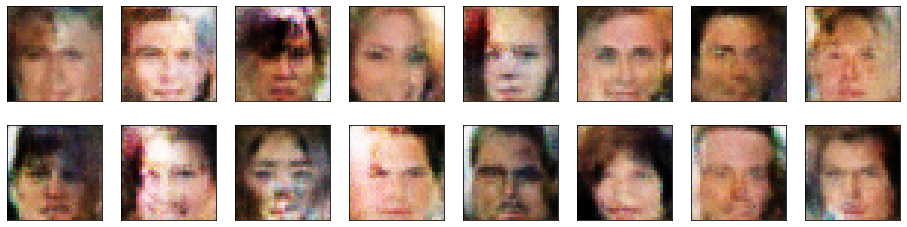

Learning rate for D has been reset.
Permanently scaling down D learning rate from 0.0003
to a new learning rate of 8.999999999999999e-05.
Learning rate for G has been reset.
Permanently scaling down G learning rate from 0.001
to a new learning rate of 0.0003.
Epoch [    2/    5] | d_loss: 0.1814 | g_loss: 0.8551
Epoch [    2/    5] | d_loss: 0.1727 | g_loss: 0.7709
Epoch [    2/    5] | d_loss: 0.1307 | g_loss: 0.7750
Epoch [    2/    5] | d_loss: 0.1236 | g_loss: 0.7995
Epoch [    2/    5] | d_loss: 0.0969 | g_loss: 0.7920
Epoch [    2/    5] | d_loss: 0.1062 | g_loss: 0.8188
Epoch [    2/    5] | d_loss: 0.1055 | g_loss: 0.8125
Epoch [    2/    5] | d_loss: 0.0988 | g_loss: 0.8170
Epoch [    2/    5] | d_loss: 0.0773 | g_loss: 0.8071
Epoch [    2/    5] | d_loss: 0.1104 | g_loss: 0.8031
Epoch [    2/    5] | d_loss: 0.0833 | g_loss: 0.8101
Epoch [    2/    5] | d_loss: 0.0811 | g_loss: 0.8328
Scaling down D learning rate from 8.999999999999999e-05
to new learning rate of 1.8e-05.
Sca

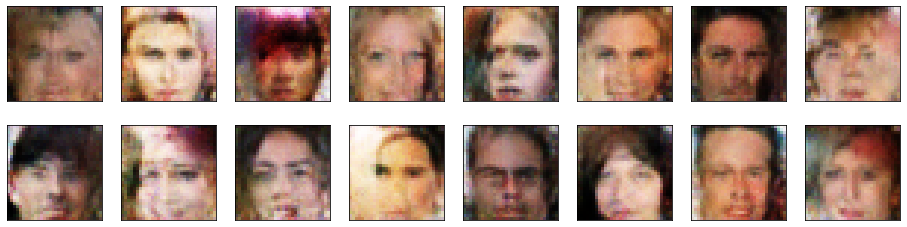

Learning rate for D has been reset.
Permanently scaling down D learning rate from 8.999999999999999e-05
to a new learning rate of 2.6999999999999996e-05.
Learning rate for G has been reset.
Permanently scaling down G learning rate from 0.0003
to a new learning rate of 8.999999999999999e-05.
Epoch [    3/    5] | d_loss: 0.1381 | g_loss: 0.7474
Epoch [    3/    5] | d_loss: 0.1034 | g_loss: 0.7887
Scaling down D learning rate from 2.6999999999999996e-05
to new learning rate of 5.399999999999999e-06.
Epoch [    3/    5] | d_loss: 0.0820 | g_loss: 0.7581
Epoch [    3/    5] | d_loss: 0.1273 | g_loss: 0.6897
Learning rate for D has been reset.
Epoch [    3/    5] | d_loss: 0.1372 | g_loss: 0.7517
Epoch [    3/    5] | d_loss: 0.0846 | g_loss: 0.7823
Epoch [    3/    5] | d_loss: 0.0866 | g_loss: 0.7798
Epoch [    3/    5] | d_loss: 0.0913 | g_loss: 0.7556
Scaling down D learning rate from 2.6999999999999996e-05
to new learning rate of 5.399999999999999e-06.
Epoch [    3/    5] | d_loss: 0.

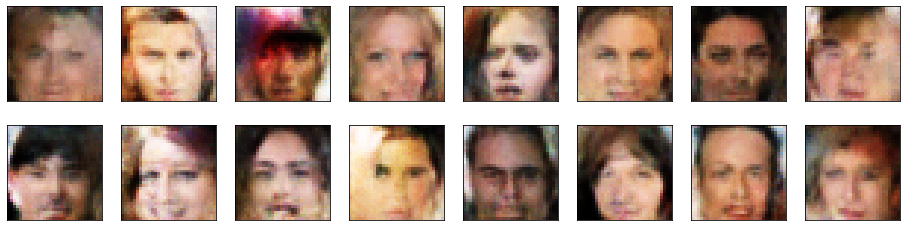

Learning rate for D has been reset.
Permanently scaling down D learning rate from 2.6999999999999996e-05
to a new learning rate of 8.099999999999999e-06.
Learning rate for G has been reset.
Permanently scaling down G learning rate from 8.999999999999999e-05
to a new learning rate of 2.6999999999999996e-05.
Epoch [    4/    5] | d_loss: 0.0792 | g_loss: 0.7936
Scaling down D learning rate from 8.099999999999999e-06
to new learning rate of 1.6199999999999997e-06.
Epoch [    4/    5] | d_loss: 0.0742 | g_loss: 0.7787
Scaling down D learning rate from 1.6199999999999997e-06
to new learning rate of 3.24e-07.
Epoch [    4/    5] | d_loss: 0.0662 | g_loss: 0.7596
Epoch [    4/    5] | d_loss: 0.0779 | g_loss: 0.7364
Epoch [    4/    5] | d_loss: 0.0923 | g_loss: 0.6995
Epoch [    4/    5] | d_loss: 0.1277 | g_loss: 0.6759
Learning rate for D has been reset.
Epoch [    4/    5] | d_loss: 0.0987 | g_loss: 0.7697
Scaling down D learning rate from 8.099999999999999e-06
to new learning rate of 1.6

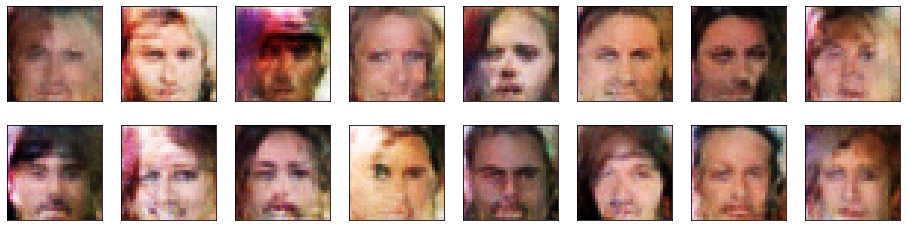

Learning rate for D has been reset.
Permanently scaling down D learning rate from 8.099999999999999e-06
to a new learning rate of 2.4299999999999996e-06.
Learning rate for G has been reset.
Permanently scaling down G learning rate from 2.6999999999999996e-05
to a new learning rate of 8.099999999999999e-06.
Epoch [    5/    5] | d_loss: 0.1118 | g_loss: 0.7133
Epoch [    5/    5] | d_loss: 0.0994 | g_loss: 0.7581
Epoch [    5/    5] | d_loss: 0.0711 | g_loss: 0.7847
Scaling down D learning rate from 2.4299999999999996e-06
to new learning rate of 4.86e-07.
Scaling down D learning rate from 4.86e-07
to new learning rate of 9.72e-08.
Scaling down D learning rate from 9.72e-08
to new learning rate of 1.944e-08.
Scaling down D learning rate from 1.944e-08
to new learning rate of 3.888000000000001e-09.
Epoch [    5/    5] | d_loss: 0.0559 | g_loss: 0.7982
Scaling down D learning rate from 3.888000000000001e-09
to new learning rate of 7.776000000000002e-10.
Scaling down D learning rate from 7.

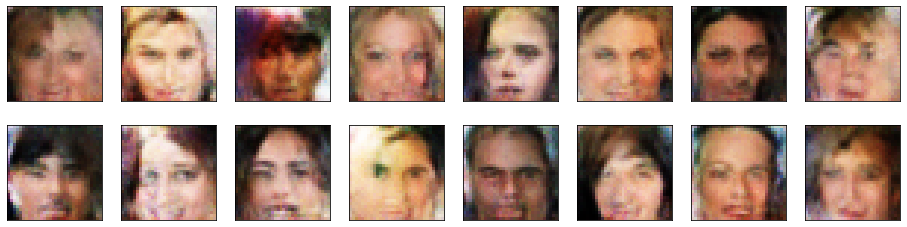

Learning rate for D has been reset.
Permanently scaling down D learning rate from 2.4299999999999996e-06
to a new learning rate of 7.289999999999998e-07.
Learning rate for G has been reset.
Permanently scaling down G learning rate from 8.099999999999999e-06
to a new learning rate of 2.4299999999999996e-06.


In [21]:
# set number of epochs 
n_epochs = 5


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=37)

In [24]:
torch.save(D.state_dict(),'D_state_dict'+run_id+'.pt')
torch.save(G.state_dict(),'G_state_dict'+run_id+'.pt')

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

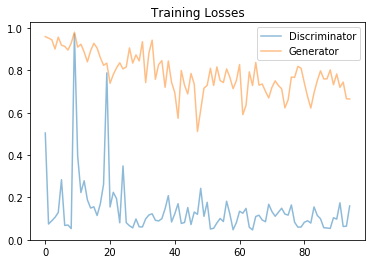

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
with open('losses'+run_id+'.pkl', 'wb') as f:
    pkl.dump(losses, f)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples'+run_id+'.pkl', 'rb') as f:
    samples = pkl.load(f)

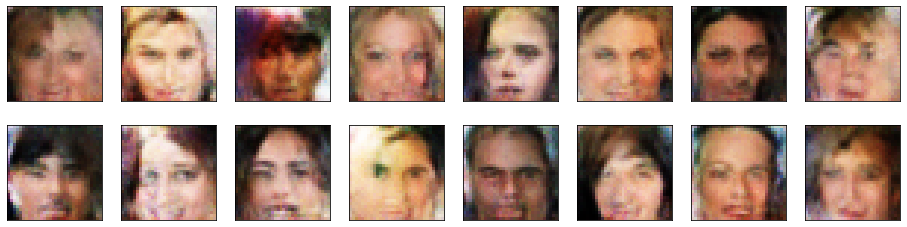

In [28]:
 _ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

My first run involved 100 epochs, with vaguely face-like results at epoch 40 and total collapse after that. My last run produced decent results even after just one epoch! It's really insane how sensitive GAN training can be.

## Training this GAN

The main issues I faced early on are [catastrophic forgetting](https://arxiv.org/abs/1807.04015) and mode collapse. The paper I just linked did have some useful advice on both counts:
- Don't have a fully connect layer! Their weight matrices tend to gradually lose rank (or approximate rank), and this encourages mode collapse. Convolutional weight matrices are much more immune to this for reasons explained in the paper.
- If the discriminator gets too good at its job, it can becomes a bad critic for the discriminator and will never help it to improve.

So I got rid of the fully connected layer and decided to just make my first convolutional layer consist of latent space coordinates directly. And I used a different learning rate for the discriminator to slow it down a bit, so that the generator has time to benefit from it before it takes off and becomes too good.

Eventually I was still having some issues with one of D or G sometimes overpowering the other, so I played around with dynamically adjusting the learning rate. Eventually I settled on two learning rate adjustments:
- When d_loss gets too low, D learning rate is temporarily lowered to give G a chance to catch up. When d_loss gets too high, G learning rate is temporarily lowered to give D a chance to catch up. This seemed to help get the networks out of certain collapse situations.
- After each epoch, I permanently scale down the learning rates for both D and G. At the first epoch I need them both to move quickly and noisily to a certain level of performance. But during later epochs I just need them to fine-tune things. Of course with usual NN training (non adversarial), one is optimizing a loss function, and the magnitude of the gradient of the loss function suitably decays the rate at which weights change as one gets closer to a good model. But I don't necessarily expect the same in the adversarial situation, and so a decaying learning rate can be really useful to help stabilize later parts of training.

After these tweaks I still found it very difficult to avoid *mode collapse*, and after looking some things up I really liked the ideas in this paper on [unrolled GANs](https://arxiv.org/abs/1611.02163). The idea is this: The ideal G is the G that performs as well as possible against the D that performs as well as possible against *that G*. During normal GAN training, we don't train G against the D that performs as well as possible, but rather against *whatever D happens to currently be*, and we just hope that since we're training D at the same time we get close enough to updating G in a good direction. Unrolled GANs allow G to *look ahead* at possible future learning steps for D, and optimize against *those*. Depending on the number of unrolling steps you choose, you can get closer to the ideal situation in which G trains against its optimal adversary.

Of all the things I tried, unrolling had by far the most profound effect on training.
- Training was a lot more stable. Instead of running circles around each other, D and G moved in a steady direction.
- Training was a lot more efficient-- instead of seeing peach blobs with eye-holds after epoch 1, I was seeing actual recognizable faces!
- I was able to massively increase learning rates compared to the usual DCGAN situation. In the end I prefered the learning rate 0.001 for G, but actually even a learning rate of 0.01 was not so bad.

## Improvements

How could I improve my model? Well I don't think there's any problem (at least not a _machine learning_ problem) with it generating mostly white faces-- that's just the distribution that it learned from and that means it's doing a good job at discovering that distribution. However if it generates _only_ white faces then we have a problem, since the generator is fooling the discriminator by only concentrating its outputs on _some of the modes_ of the data distribution, rather than capturing the finer details of the distribution.

That being said, the model did manage to generate some black people, which I think would've been very difficult to achieve without the unrolling steps.

I think a good improvement would be to generate higher quality images-- like 64 by 64 images. This might require a deeper model, which I think I could try out by increasing the number of residual blocks (the n_res parameter) in my G and D.

One deficiency of my training setup is that making D and G deeper (say by increasing n_res parameter in their definition) tends to lead to catastrophic forgetting eventually in training. This can probably be alleviated by setting up learning rate decay parameters appropriately, but I couldn't quite get it right. In the end, I just stuck with a less deep model that got the job done.

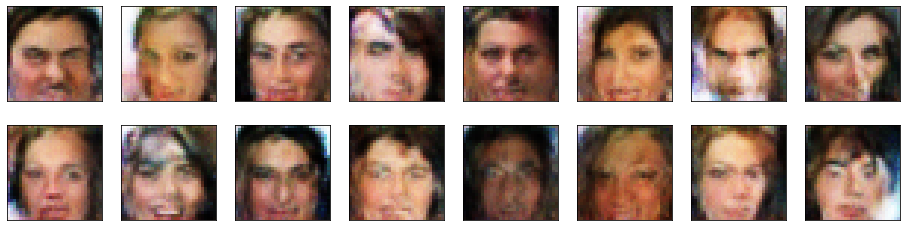

In [66]:
# Looking at some other generator outputs for fun.

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
# move z to GPU if available
if train_on_gpu:
    fixed_z = fixed_z.cuda()

G.eval()
view_sample(G(fixed_z))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.